In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import choice

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls "/content/gdrive/MyDrive/Colab Notebooks/09_InceptionResNetV2_Safety_Vest/DataSet"

EVAL_data  TEST_data  TRAIN_data


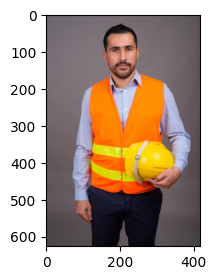

In [4]:
# Select a random image from the  train dataset

# Define the path to dataset
dataset_path = "/content/gdrive/MyDrive/Colab Notebooks/09_InceptionResNetV2_Safety_Vest/DataSet/TRAIN_data"

class_name = choice(['without_vest', 'with_vest'])
class_path = os.path.join(dataset_path, class_name)

image_name = choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# Read and Display the random image in RGB format
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.show()

In [5]:
# Define the data generator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True)

# Define the data generator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Define the training, validation, and test data generators
train_generator = train_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/09_InceptionResNetV2_Safety_Vest/DataSet/TRAIN_data",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_vest', 'with_vest']
    )

val_generator = val_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/09_InceptionResNetV2_Safety_Vest/DataSet/EVAL_data",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_vest', 'with_vest'],
    shuffle=False)


test_generator = test_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/09_InceptionResNetV2_Safety_Vest/DataSet/TEST_data",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_vest', 'with_vest'],
    shuffle=False)

Found 4940 images belonging to 2 classes.
Found 570 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [6]:
# Load the pre-trained inception model with the weights of ImageNet
inception = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the first 2 blocks of layers
for layer in inception.layers[:249]:
    layer.trainable = False
for layer in inception.layers[249:]:
    layer.trainable = True

# Add a new fully connected layer on top of the pre-trained model
x = Flatten()(inception.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create a new model that includes both the pre-trained model and the new layers
model = Model(inputs=inception.input, outputs=x)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
# model.summary()

In [7]:
# Create a ModelCheckpoint callback that saves the best model after each epoch, based on validation accuracy
checkpoint = ModelCheckpoint(
      '/content/gdrive/MyDrive/Colab Notebooks/09_InceptionResNetV2_Safety_Vest/my_inception_model.tf',
      monitor = 'val_accuracy',
      verbose = 0,
      save_best_only = True,
      save_weights_only = False,
      mode = "auto",
      save_freq="epoch",
      initial_value_threshold=None
      )

In [8]:
# Train the model using the fit() method
history = model.fit(
   train_generator, # The training data generator
   steps_per_epoch=train_generator.samples // batch_size, # The number of steps (batches) per epoch
   validation_data=val_generator, # The validation data generator
   validation_steps=val_generator.samples // batch_size, # The number of steps (batches) per validation epoch
   epochs=16,    # The number of epochs to train the model for
   callbacks=[checkpoint])

Epoch 1/16
154/154 [==============================] - 1574s 10s/step - loss: 0.3625 - accuracy: 0.9264 - val_loss: 0.3364 - val_accuracy: 0.9320
Epoch 2/16
154/154 [==============================] - 112s 725ms/step - loss: 0.0684 - accuracy: 0.9766 - val_loss: 1.1434 - val_accuracy: 0.6452
Epoch 3/16
154/154 [==============================] - 190s 1s/step - loss: 0.0579 - accuracy: 0.9857 - val_loss: 0.0761 - val_accuracy: 0.9835
Epoch 4/16
154/154 [==============================] - 204s 1s/step - loss: 0.0691 - accuracy: 0.9788 - val_loss: 0.0614 - val_accuracy: 0.9871
Epoch 5/16
154/154 [==============================] - 195s 1s/step - loss: 0.0495 - accuracy: 0.9843 - val_loss: 0.0168 - val_accuracy: 0.9963
Epoch 6/16
154/154 [==============================] - 124s 806ms/step - loss: 0.0390 - accuracy: 0.9861 - val_loss: 0.2503 - val_accuracy: 0.9651
Epoch 7/16
154/154 [==============================] - 108s 700ms/step - loss: 0.0605 - accuracy: 0.9819 - val_loss: 0.1174 - val_accur

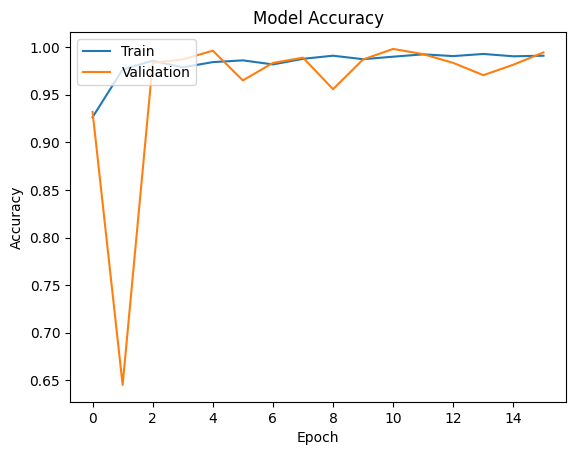

In [9]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
# Load the model saved by the checkpoint
top_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/09_InceptionResNetV2_Safety_Vest/my_inception_model.tf')

In [11]:
# Generate predictions for the validation set
y_pred = top_model.predict(val_generator)

# Convert the predicted probabilities to binary labels
y_pred = y_pred > 0.5

# Get the true labels of the validation set
y_true = val_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred).astype(int)

# Print the confusion matrix with integer values
print('Confusion Matrix:')
print(conf_matrix)

18/18 [==============================] - 9s 313ms/step
Confusion Matrix:
[[284   1]
 [  0 285]]


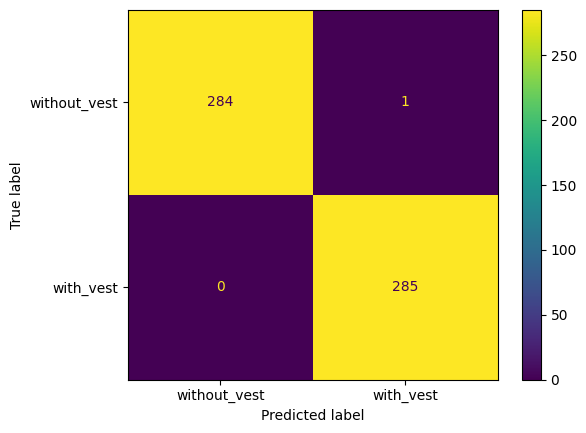

In [12]:
# Define the class labels
class_labels = ['without_vest', 'with_vest']
# Create the confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
cm_display.plot()
plt.show()

In [13]:
# Calculate the precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=['without_vest', 'with_vest'])

# Print the report
print(report)

              precision    recall  f1-score   support

without_vest       1.00      1.00      1.00       285
   with_vest       1.00      1.00      1.00       285

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570



In [14]:
def preprocess_image_to_test(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image while maintaining its aspect ratio
    h, w, _ = image.shape
    if h > w:
        ratio = 224 / h
    else:
        ratio = 224 / w
    resized_img = cv2.resize(image, (int(w * ratio), int(h * ratio)), interpolation=cv2.INTER_AREA)

    # Add padding to make the image 224x224
    h, w, _ = resized_img.shape
    pad_h = (224 - h) // 2
    pad_w = (224 - w) // 2
    padded_img = cv2.copyMakeBorder(resized_img, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT)

    # Preprocess the image
    image = np.expand_dims(padded_img, axis=0)
    image = image / 255.0

    # Resize the image to (224, 224, 3)
    image = cv2.resize(image[0], (224, 224), interpolation=cv2.INTER_AREA)
    image = np.expand_dims(image, axis=0)

    return image

##############################################

 Processing random image in folder with_vest...


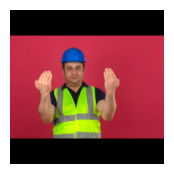

1/1 [==============================] - 5s 5s/step
The model predicts that the image contains a safety vest.

##############################################

 Processing random image in folder without_vest...



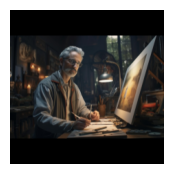

1/1 [==============================] - 0s 42ms/step
The model predicts that the image does NOT contain a safety vest.

##############################################

 Processing random image in folder with_vest...



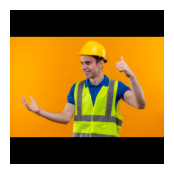

1/1 [==============================] - 0s 49ms/step
The model predicts that the image contains a safety vest.

##############################################

 Processing random image in folder without_vest...



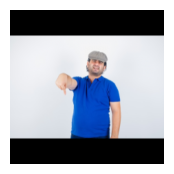

1/1 [==============================] - 0s 43ms/step
The model predicts that the image does NOT contain a safety vest.

##############################################

 Processing random image in folder with_vest...


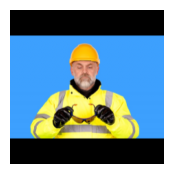

1/1 [==============================] - 0s 43ms/step
The model predicts that the image contains a safety vest.

##############################################

 Processing random image in folder with_vest...



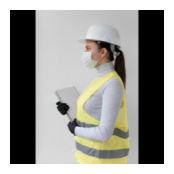

1/1 [==============================] - 0s 43ms/step
The model predicts that the image contains a safety vest.

##############################################

 Processing random image in folder without_vest...


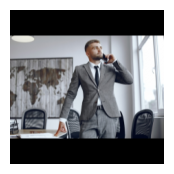

1/1 [==============================] - 0s 39ms/step
The model predicts that the image does NOT contain a safety vest.

##############################################

 Processing random image in folder without_vest...



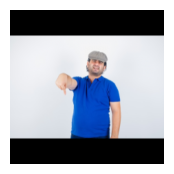

1/1 [==============================] - 0s 43ms/step
The model predicts that the image does NOT contain a safety vest.

##############################################


In [15]:
# Define the path to the test data directory
dataset_path = "/content/gdrive/MyDrive/Colab Notebooks/09_InceptionResNetV2_Safety_Vest/DataSet/TEST_data"
print("##############################################")
# Loop 10 times
for i in range(8):
    # Choose a random folder
    folder = choice(os.listdir(dataset_path))
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        print(f"\n Processing random image in folder {folder}...")
        # Choose a random image
        image_file = choice(os.listdir(folder_path))
        image_path = os.path.join(folder_path, image_file)
        # Preprocess the image
        image = preprocess_image_to_test(image_path)
        # Print the image
        plt.figure(figsize=(2, 2))
        plt.imshow(image[0], vmin=0, vmax=1)
        plt.axis('off')
        print()
        plt.show()
        # Make a prediction
        prediction = top_model.predict(image)
        if prediction > 0.5:
            print(f"The model predicts that the image contains a safety vest.\n")
        else:
            print(f"The model predicts that the image does NOT contain a safety vest.\n")
        print("##############################################")